[![在 Colab 中打开](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/trim-filter-messages.ipynb) [![在 LangChain Academy 中打开](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239435-lesson-4-trim-and-filter-messages)


# 过滤与裁剪消息

## 回顾

现在我们已经进一步理解了下面这些内容：

* 如何自定义图状态 schema
* 如何定义自定义状态 reducer
* 如何使用多种图状态 schema

## 目标

接下来我们把这些概念与 LangGraph 中的模型结合起来！

在接下来的几节课里，我们会构建一个拥有长期记忆的聊天机器人。

既然聊天机器人会处理消息，我们先来聊聊在图状态中操作消息的一些进阶方法。


In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

In [2]:
import os, getpass


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("DASHSCOPE_API_KEY")

我们将使用 [LangSmith](https://docs.smith.langchain.com/) 进行[追踪](https://docs.smith.langchain.com/concepts/tracing)。

我们会把日志记录到项目 `langchain-academy`。


In [3]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## 消息即状态

首先先定义几条消息。


In [4]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]
messages.append(
    HumanMessage(
        f"Yes, I know about whales. But what others should I learn about?", name="Lance"
    )
)

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?


回顾一下，我们可以把它们传给聊天模型。


In [5]:
# !pip install ipywidgets jupyter --quiet

In [6]:
# from langchain_openai import ChatOpenAI

# llm = ChatOpenAI(model="gpt-4o")

from langchain_community.chat_models import ChatTongyi

llm = ChatTongyi(model="qwen-plus")
llm.invoke(messages)

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


AIMessage(content='Great! Whales are fascinating, but there are several other amazing ocean mammals worth learning about. Here are some key groups of marine mammals beyond whales:\n\n1. **Dolphins**  \n   - Part of the *cetacean* family (like whales and porpoises).  \n   - Highly intelligent and social animals—some species use echolocation and complex communication.  \n   - The bottlenose dolphin is one of the most well-known, but there are over 90 species, including orcas (killer whales), which are actually the largest dolphins!\n\n2. **Porpoises**  \n   - Similar to dolphins but generally smaller with more rounded bodies and shorter beaks.  \n   - Less vocal and less acrobatic than dolphins.  \n   - Examples: harbor porpoise, Dall’s porpoise.\n\n3. **Seals, Sea Lions, and Walruses (Pinnipeds)**  \n   - These are semi-aquatic mammals that spend time both in water and on land/ice.  \n   - **Seals**: Move awkwardly on land; no external ears.  \n   - **Sea lions**: More agile on land; ha

我们可以在一个使用 `MessagesState` 的简单图中运行聊天模型。


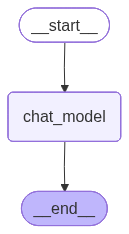

In [7]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END


# Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}


# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
output = graph.invoke({"messages": messages})
for m in output["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great! Whales are fascinating, but there are many other amazing ocean mammals worth learning about. Here are some key groups of marine mammals beyond whales:

1. **Dolphins**  
   - Part of the cetacean family (like whales and porpoises).  
   - Highly intelligent and social—often seen in pods.  
   - The bottlenose dolphin is one of the most well-known species.  
   - Some dolphins, like the orca (killer whale), are actually the largest members of the dolphin family!

2. **Porpoises**  
   - Similar to dolphins but generally smaller with more rounded bodies and shorter beaks.  
   - Less vocal and less ac

## Reducer

处理消息时，一个实际问题是如何管理长期对话。

如果不加以控制，每次向模型传入不断增长的消息列表会导致 token 使用量和延迟大幅增加。

我们有几种方式可以应对。

首先，回顾一下我们用过的技巧：结合 `RemoveMessage` 与 `add_messages` reducer。


In [9]:
from langchain_core.messages import RemoveMessage


# Nodes
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}


def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"])]}


# Build graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
# display(Image(graph.get_graph().draw_mermaid_png(max_retries=15, retry_delay=2.0)))

In [10]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(
    AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3")
)
messages.append(
    HumanMessage(
        "Yes, I know about whales. But what others should I learn about?",
        name="Lance",
        id="4",
    )
)

# Invoke
output = graph.invoke({"messages": messages})
for m in output["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great! Whales are fascinating, but there’s a whole world of ocean mammals beyond them. Here are some other major groups you should learn about:

1. **Dolphins**  
   - Highly intelligent and social, dolphins are part of the *toothed whale* family (odontocetes), which also includes whales like orcas.
   - Species include bottlenose dolphins, spinner dolphins, and the larger orca (also called killer whale).
   - Found in oceans worldwide and even some rivers (like the Amazon river dolphin).

2. **Porpoises**  
   - Often confused with dolphins, porpoises are smaller, have more rounded bodies, and different t

## 筛选消息

如果你不需要（或不想）修改图状态，也可以只筛选传给聊天模型的消息。

例如，只把过滤后的列表 `llm.invoke(messages[-1:])` 传给模型。


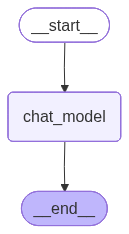

In [11]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}


# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

我们取出已有的消息列表，追加上面的 LLM 回复，再追加一个跟进问题。


In [12]:
messages.append(output["messages"][-1])
messages.append(HumanMessage(f"Tell me more about Narwhals!", name="Lance"))

In [13]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great! Whales are fascinating, but there’s a whole world of ocean mammals beyond them. Here are some other major groups you should learn about:

1. **Dolphins**  
   - Highly intelligent and social, dolphins are part of the *toothed whale* family (odontocetes), which also includes whales like orcas.
   - Species include bottlenose dolphins, spinner dolphins, and the larger orca (also called killer whale).
   - Found

In [13]:
# Invoke, using message filtering
output = graph.invoke({"messages": messages})
for m in output["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great! Whales are fascinating, but there’s a whole world of ocean mammals beyond them. Here are some other major groups you should definitely learn about:

### 1. **Dolphins**
- Part of the *cetacean* family (like whales and porpoises).
- Highly intelligent and social.
- Include species like the bottlenose dolphin, orca (killer whale), and spinner dolphin.
- Use echolocation to navigate and hunt.

💡 Fun fact: Orcas 

状态里包含所有消息。

不过看看 LangSmith trace，就会发现模型调用只使用了最后一条消息：

https://smith.langchain.com/public/75aca3ce-ef19-4b92-94be-0178c7a660d9/r


## 裁剪消息

另一种做法是按 token 数[裁剪消息](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens)。

这样可以把消息历史限制在指定的 token 数以内。

筛选只是在交互后返回部分消息，而裁剪则限制了聊天模型在响应时可用的 token 数。

参见下方的 `trim_messages`。


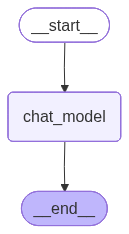

In [14]:
from langchain_core.messages import trim_messages

# from langchain_openai import ChatOpenAI


# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
        state["messages"],
        max_tokens=100,
        strategy="last",
        # token_counter=ChatOpenAI(model="gpt-4o"),
        token_counter=ChatTongyi(model="qwen-plus"),
        allow_partial=False,
    )
    return {"messages": [llm.invoke(messages)]}


# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
messages.append(output["messages"][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Lance"))

In [16]:
# Example of trimming messages
import transformers

trim_messages(
    messages,
    max_tokens=100,
    strategy="last",
    # token_counter=ChatOpenAI(model="gpt-4o"),
    token_counter=ChatTongyi(model="qwen-plus"),
    allow_partial=False,
)

[HumanMessage(content='Tell me where Orcas live!', additional_kwargs={}, response_metadata={}, name='Lance')]

In [17]:
# Invoke, using message trimming in the chat_model_node
messages_out_trim = graph.invoke({"messages": messages})

In [18]:
# Example of trimming messages
import transformers

trim_messages(
    messages,
    max_tokens=100,
    strategy="last",
    # token_counter=ChatOpenAI(model="gpt-4o"),
    token_counter=ChatTongyi(model="qwen-plus"),
    allow_partial=True,
)

[AIMessage(content='   - Excellent swimmers and apex predators of the Arctic.\n\nEach of these animals has unique adaptations for life in the ocean—from blubber for insulation to specialized diving abilities and complex communication.\n\nWould you like to dive deeper into any of these groups? For example, we could explore how dolphins use echolocation or why sea otters are vital to marine ecosystems.', additional_kwargs={}, response_metadata={'model_name': 'qwen-plus', 'finish_reason': 'stop', 'request_id': 'a26ff493-5afb-4e59-b827-faf950012783', 'token_usage': {'input_tokens': 42, 'output_tokens': 603, 'total_tokens': 645, 'prompt_tokens_details': {'cached_tokens': 0}}}, id='run--8e4412e7-e7a7-4054-b22a-cf6e3a2e8b6a-0'),
 HumanMessage(content='Tell me where Orcas live!', additional_kwargs={}, response_metadata={}, name='Lance', id='61c66186-0af1-4f76-ac92-0990dcb20fdc')]

In [19]:
# Invoke, using message trimming in the chat_model_node
messages_out_trim = graph.invoke({"messages": messages})

看看 LangSmith trace，了解这次模型调用的实际情况：

https://smith.langchain.com/public/b153f7e9-f1a5-4d60-8074-f0d7ab5b42ef/r
